In [1]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from scimilarity.utils import lognorm_counts, align_dataset, get_centroid
from scimilarity import CellEmbedding, CellQuery
import os
random_seed = 42
np.random.seed(random_seed)

import pandas as pd

sc.set_figure_params(dpi=100)

In [2]:
# Instantiate the CellQuery object
# Set model_path to the location of the uncompressed model
model_path = "/workspace/models/model_v1.1"
cq = CellQuery(model_path, use_gpu=True)

In [3]:
data_path = "/workspace/NB_bone_Met_preprocessed.h5ad"
data = sc.read(data_path)
print(f"Data cell 1: {data.obs['cell1']}")

subset = data[data.obs['cell1'].isin(["B cells", "T cells", "myeloid", "immature B", "Neutrophil", "progenitor"])]
print(f"Subset: {subset}")

Data cell 1: cell_ID
NBBM1_AAACGAAGTCCGGCAT-1           T cells
NBBM1_AAACGCTGTCACAATC-1           T cells
NBBM1_AAAGGATGTAGGCTGA-1           B cells
NBBM1_AAAGGTAGTCTCAGGC-1           B cells
NBBM1_AAAGGTAGTGAGTGAC-1           T cells
                                   ...    
NB34_Bone_TTTGTTGAGCGAAACC-1       T cells
NB34_Bone_TTTGTTGAGTCGCTAT-1    Neutrophil
NB34_Bone_TTTGTTGAGTCGGCAA-1       T cells
NB34_Bone_TTTGTTGGTAAGGCTG-1       T cells
NB34_Bone_TTTGTTGGTGCGTGCT-1       B cells
Name: cell1, Length: 36763, dtype: category
Categories (13, object): ['B cells', 'NK', 'Neutrophil', 'T cells', ..., 'plasma', 'pro B', 'proerythroblast', 'progenitor']
Subset: View of AnnData object with n_obs × n_vars = 29935 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA

In [4]:
subset.X = subset.layers['RNA']
subset.layers['counts']=subset.layers['RNA']

subset = align_dataset(subset, cq.gene_order)
subset = lognorm_counts(subset)

In [5]:
subset.obsm["X_scimilarity"] = cq.get_embeddings(subset.X)


In [6]:
sc.pp.neighbors(subset, use_rep="X_scimilarity")
sc.tl.umap(subset)

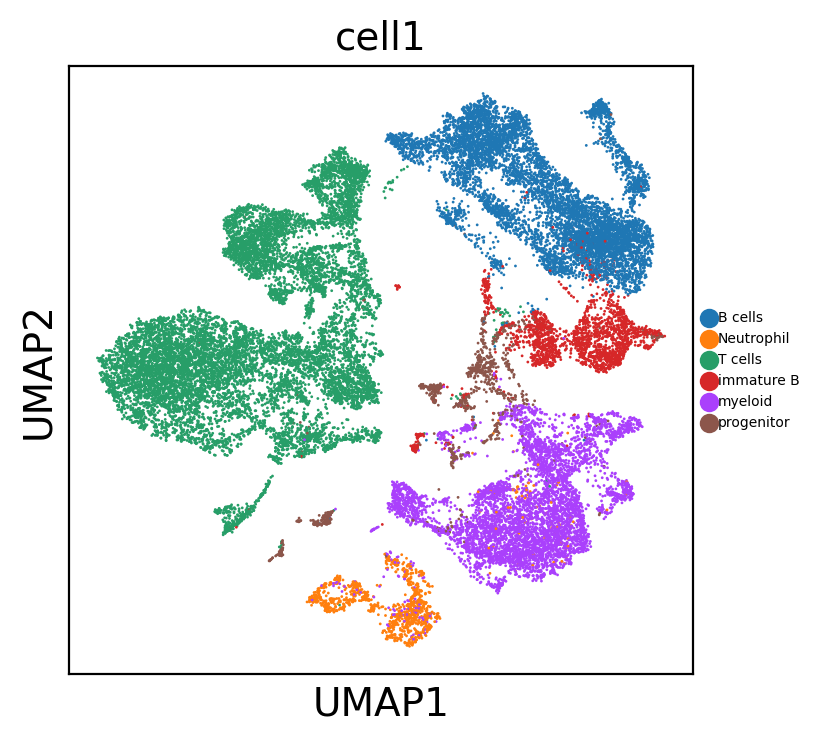

In [8]:
sc.pl.umap(subset, color="cell1", legend_fontsize=5)


In [11]:
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = [6, 4]

import warnings

warnings.filterwarnings("ignore")

In [15]:
cells_used_in_query = subset.obs["cell1"] == "B cells"
subset.obs["b_cell_query"] = cells_used_in_query.astype(int)

In [16]:
cells_used_in_query = subset.obs["cell1"] == "T cells"
subset.obs["t_cell_query"] = cells_used_in_query.astype(int)

In [17]:
cells_used_in_query = subset.obs["cell1"] == "myeloid"
subset.obs["myeloid_query"] = cells_used_in_query.astype(int)

In [18]:
cells_used_in_query = subset.obs["cell1"] == "immature B"
subset.obs["immature_b_query"] = cells_used_in_query.astype(int)

In [19]:
cells_used_in_query = subset.obs["cell1"] == "Neutrophil"
subset.obs["neutrophil_query"] = cells_used_in_query.astype(int)

In [20]:
cells_used_in_query = subset.obs["cell1"] == "progenitor"
subset.obs["progenitor_query"] = cells_used_in_query.astype(int)

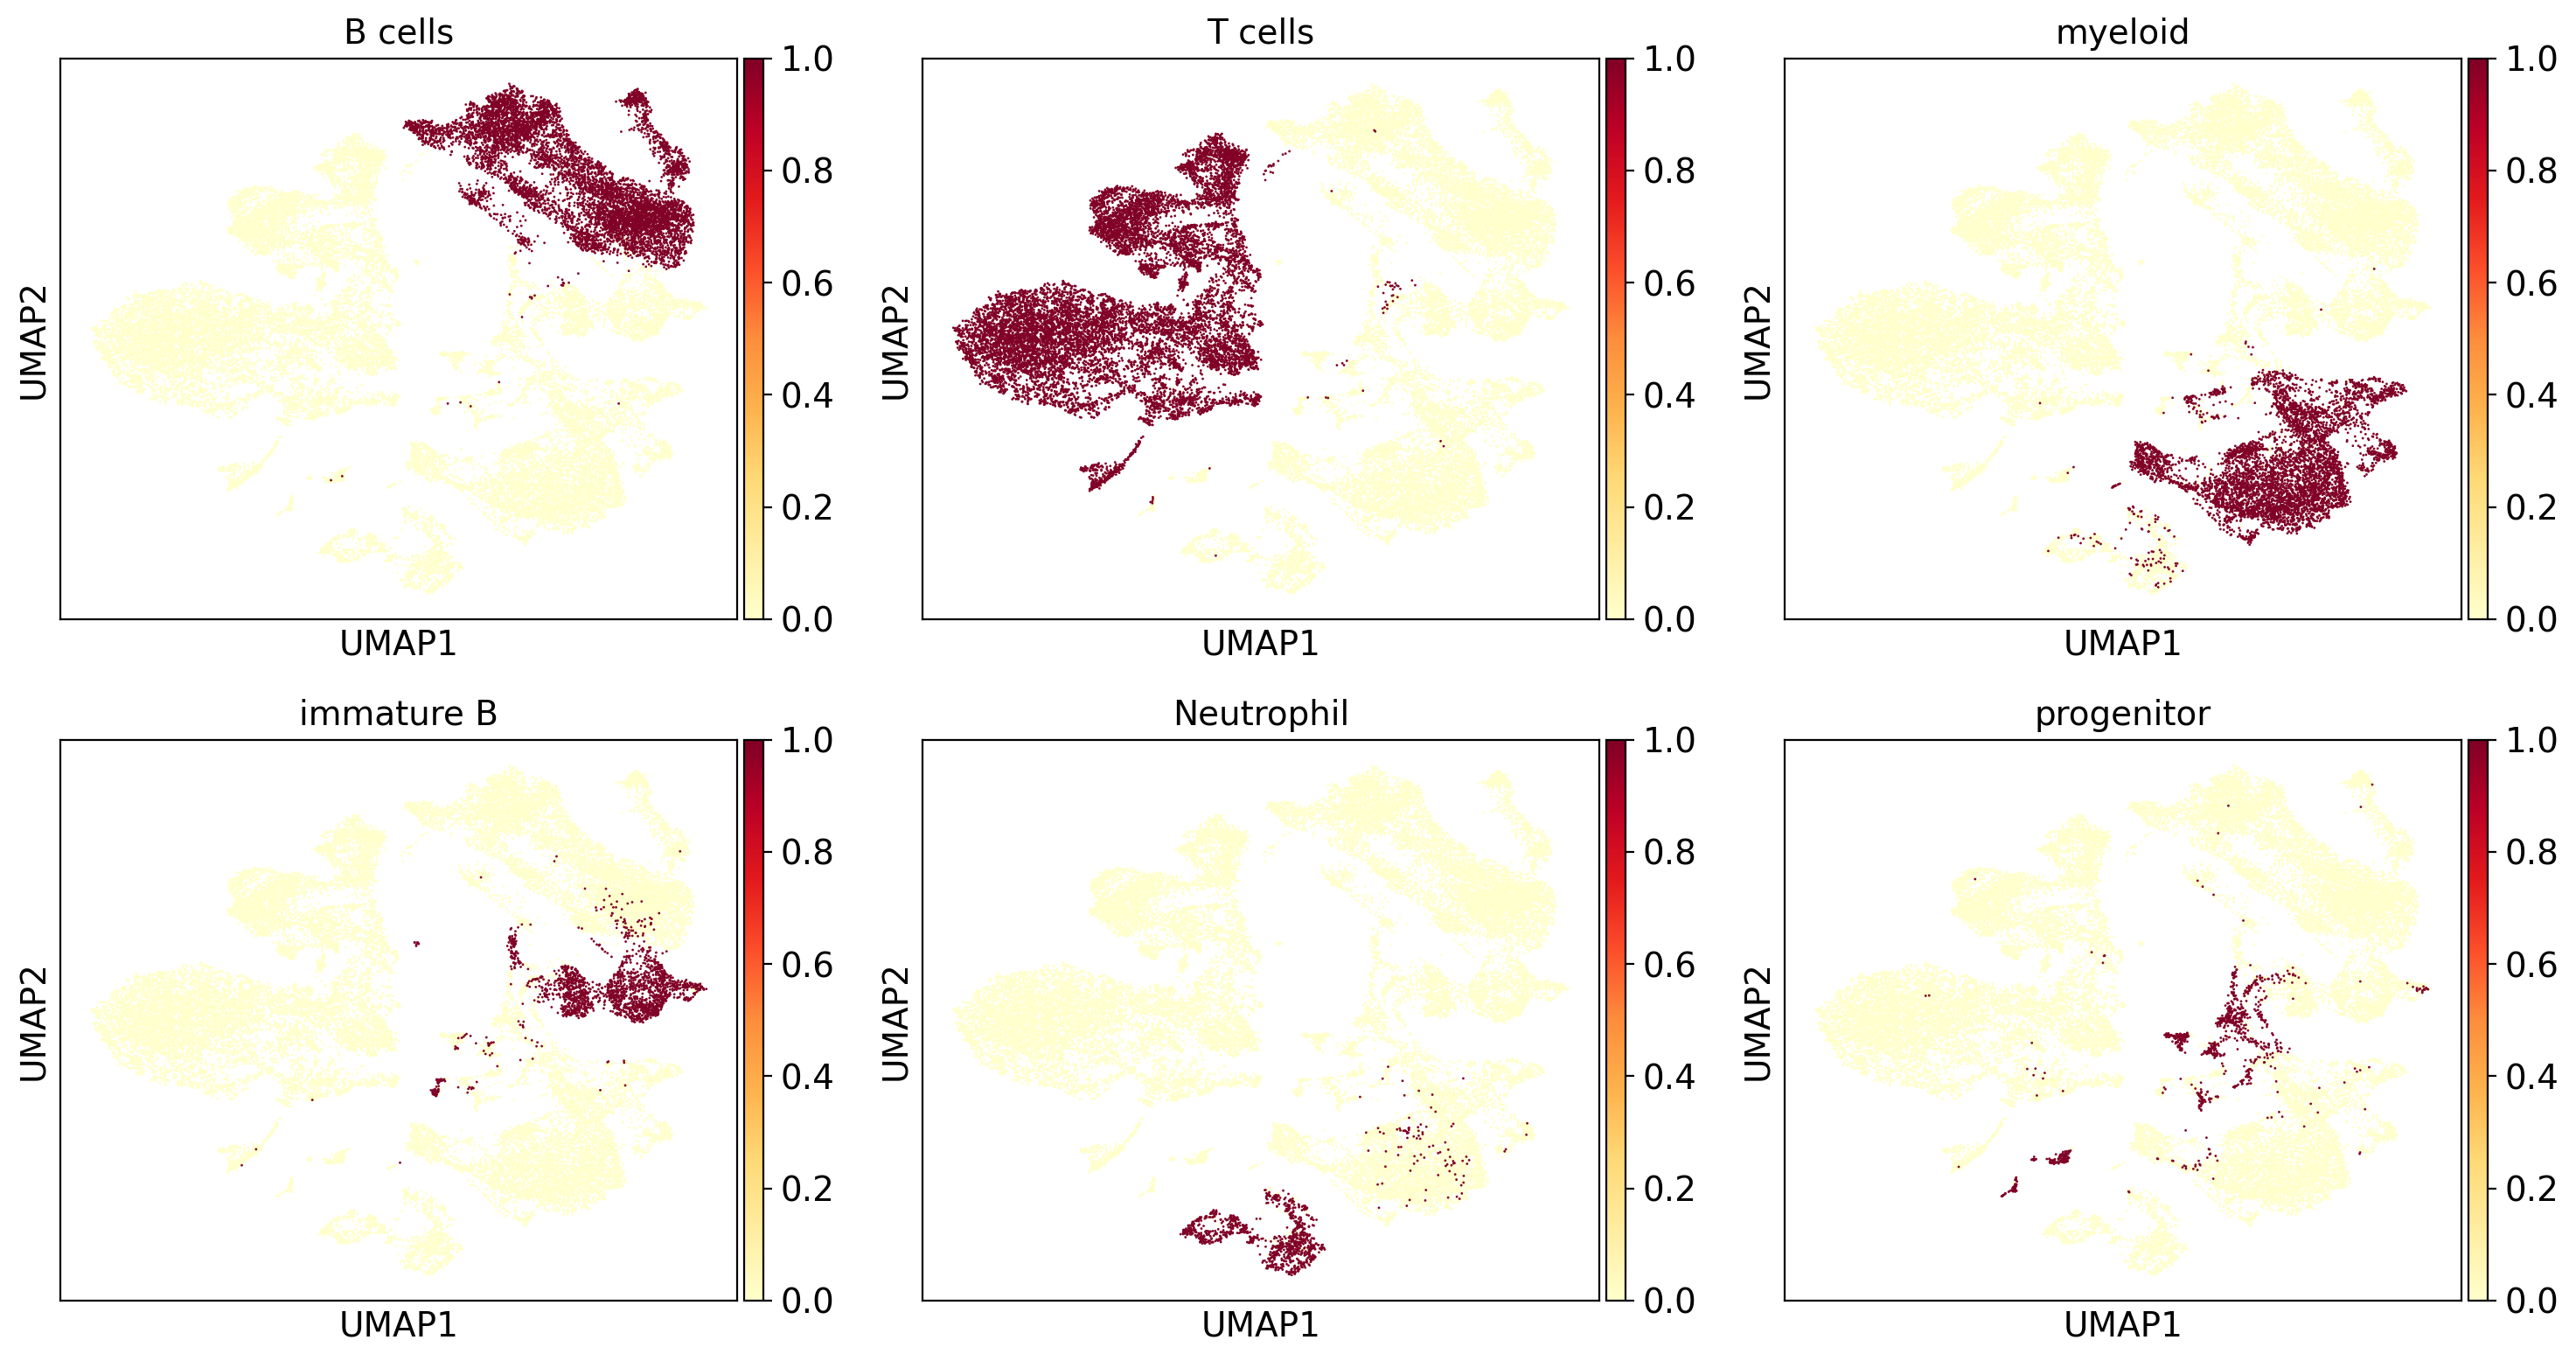

In [24]:
fig, axes = plt.subplots(2,3,figsize = (15,8))
axes = axes.flatten()
titles = ["B cells", "T cells", "myeloid", "immature B", "Neutrophil", "progenitor"]
for i, col in enumerate(["b_cell_query", "t_cell_query", "myeloid_query", "immature_b_query", "neutrophil_query", "progenitor_query"]):
    sc.pl.umap(
        subset,
        color=col,
        title=titles[i],
        cmap="YlOrRd",
        ax = axes[i],
        show = False
    )

fig.tight_layout()

In [37]:
centroid_embedding, nn_idxs, nn_dists, b_cell_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "b_cell_query"
)
print(qc_stats)

{'query_coherence': 58.3}


In [38]:
centroid_embedding, nn_idxs, nn_dists, t_cell_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "t_cell_query"
)
print(qc_stats)

{'query_coherence': 3.8}


In [39]:
centroid_embedding, nn_idxs, nn_dists, myeloid_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "myeloid_query"
)
print(qc_stats)

{'query_coherence': 1.3}


In [40]:
centroid_embedding, nn_idxs, nn_dists, immature_b_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "immature_b_query"
)
print(qc_stats)

{'query_coherence': 34.6}


In [41]:
centroid_embedding, nn_idxs, nn_dists, neutrophil_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "neutrophil_query"
)
print(qc_stats)

{'query_coherence': 31.2}


In [42]:
centroid_embedding, nn_idxs, nn_dists, progenitor_metadata, qc_stats = cq.search_centroid_nearest(
    subset, "progenitor_query"
)
print(qc_stats)

{'query_coherence': 10.6}


In [43]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100 * study_proportions / study_proportions.sum()


def plot_proportions(df, title=None):
    ax = df.plot(
        kind="barh", xlabel="percent of cells", title=title, grid=False, figsize=(8, 5)
    )
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xticklabels([f"{int(tick)}%" for tick in ax.get_xticks()])
    plt.tight_layout()

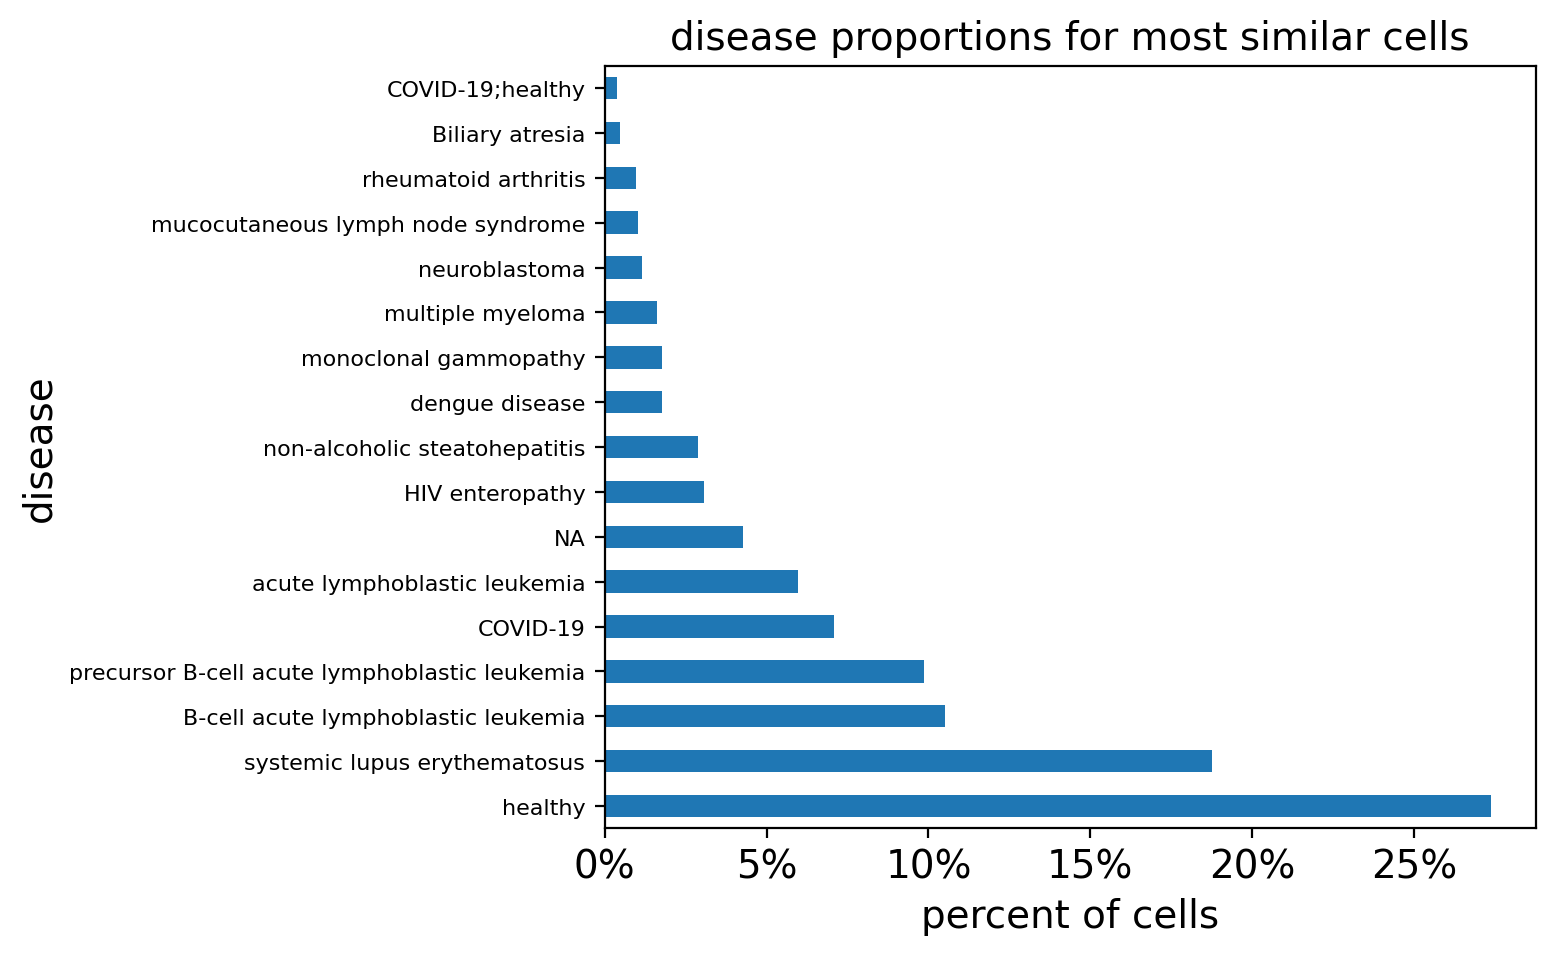

In [44]:
query_study = "DS000011735"
filtered_result_metadata = b_cell_metadata[b_cell_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

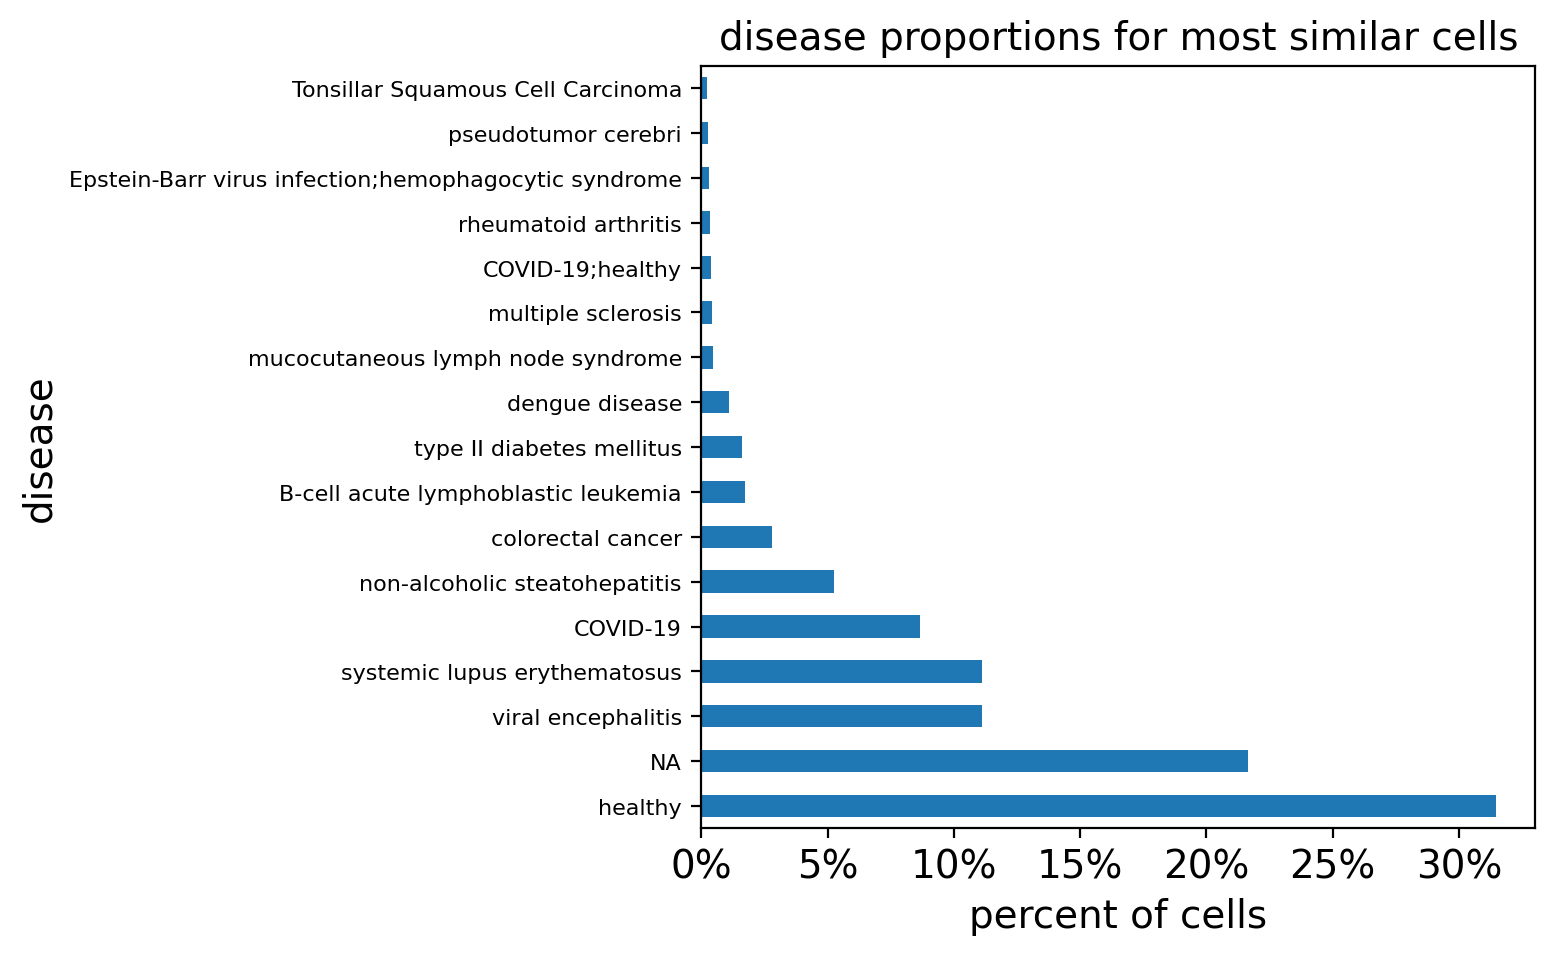

In [45]:
query_study = "DS000011735"
filtered_result_metadata = t_cell_metadata[t_cell_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

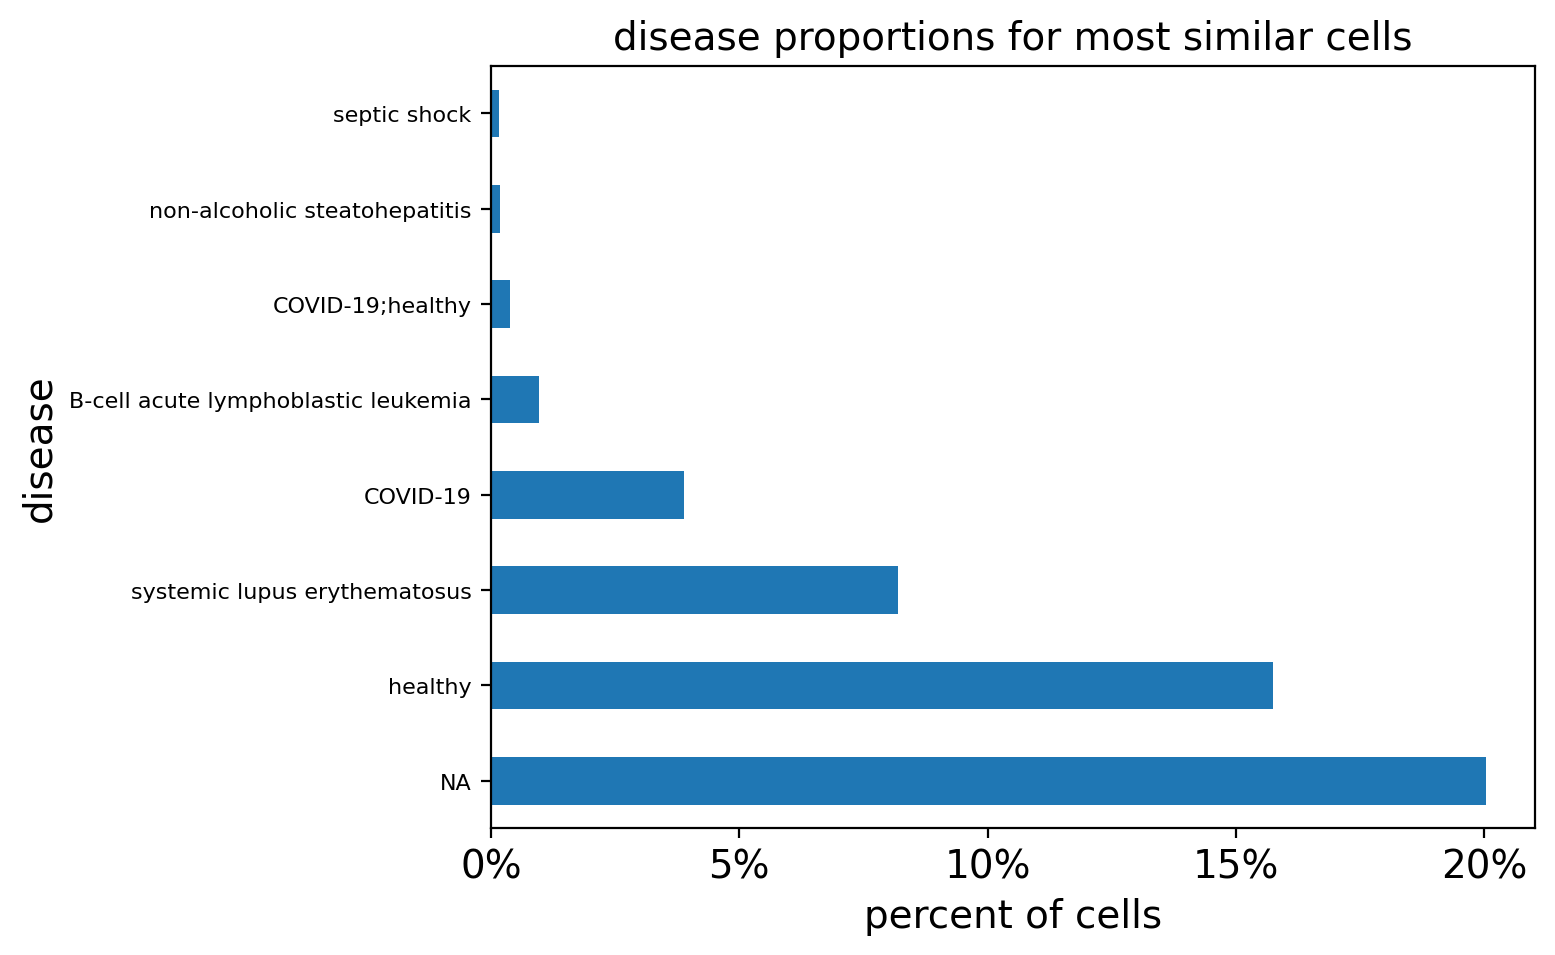

In [46]:
query_study = "DS000011735"
filtered_result_metadata = myeloid_metadata[myeloid_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

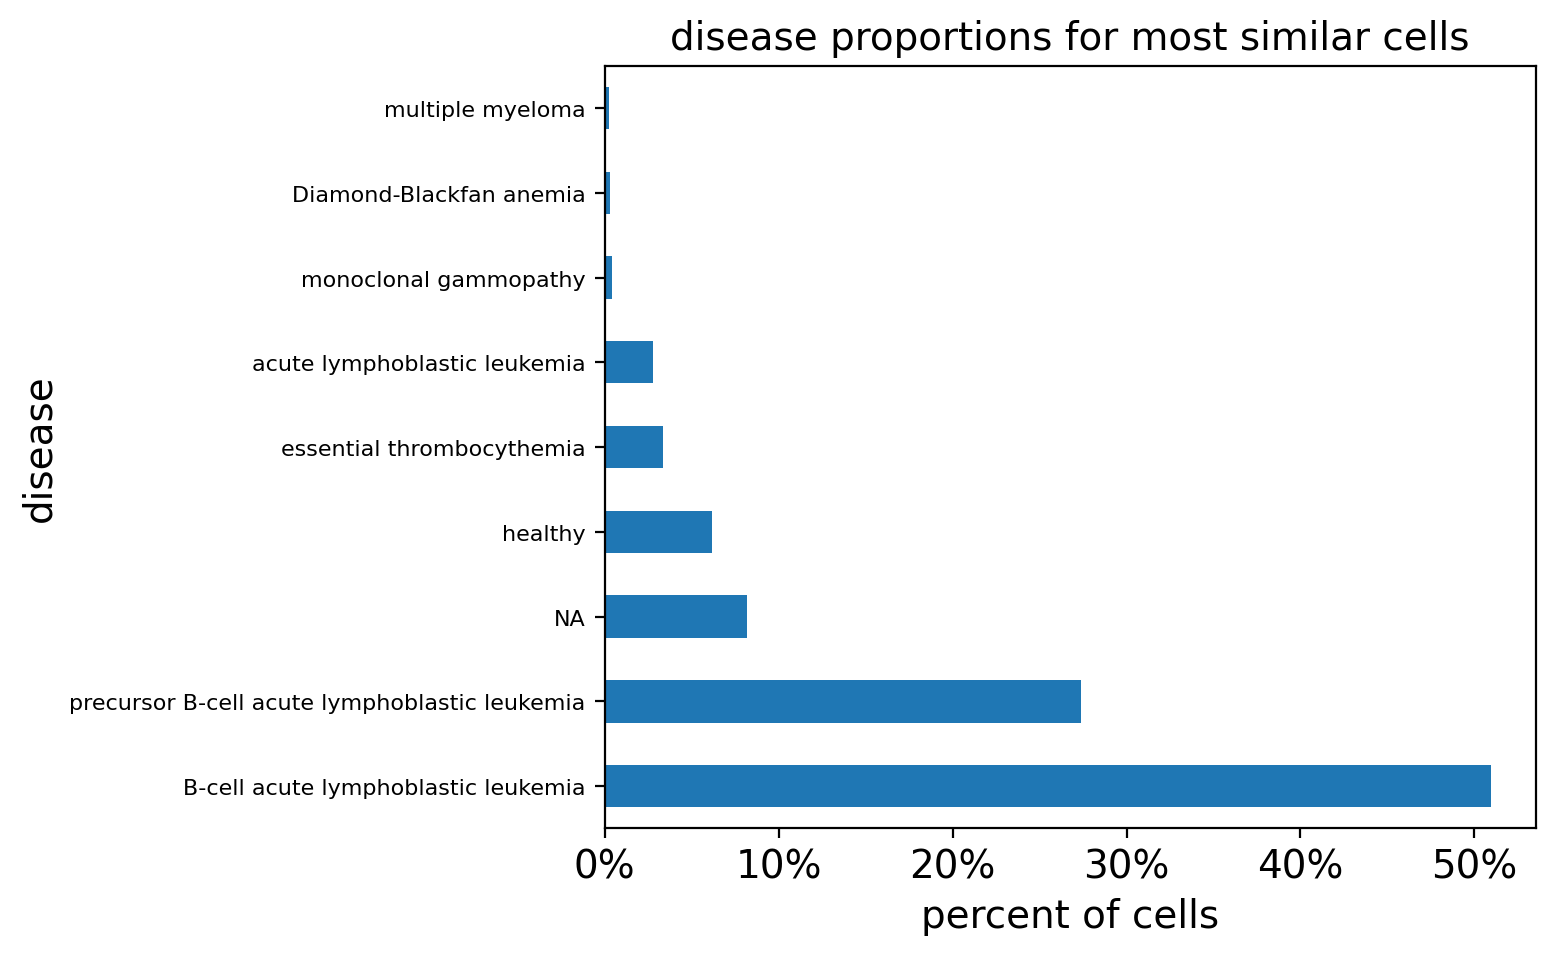

In [47]:
query_study = "DS000011735"
filtered_result_metadata = immature_b_metadata[immature_b_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

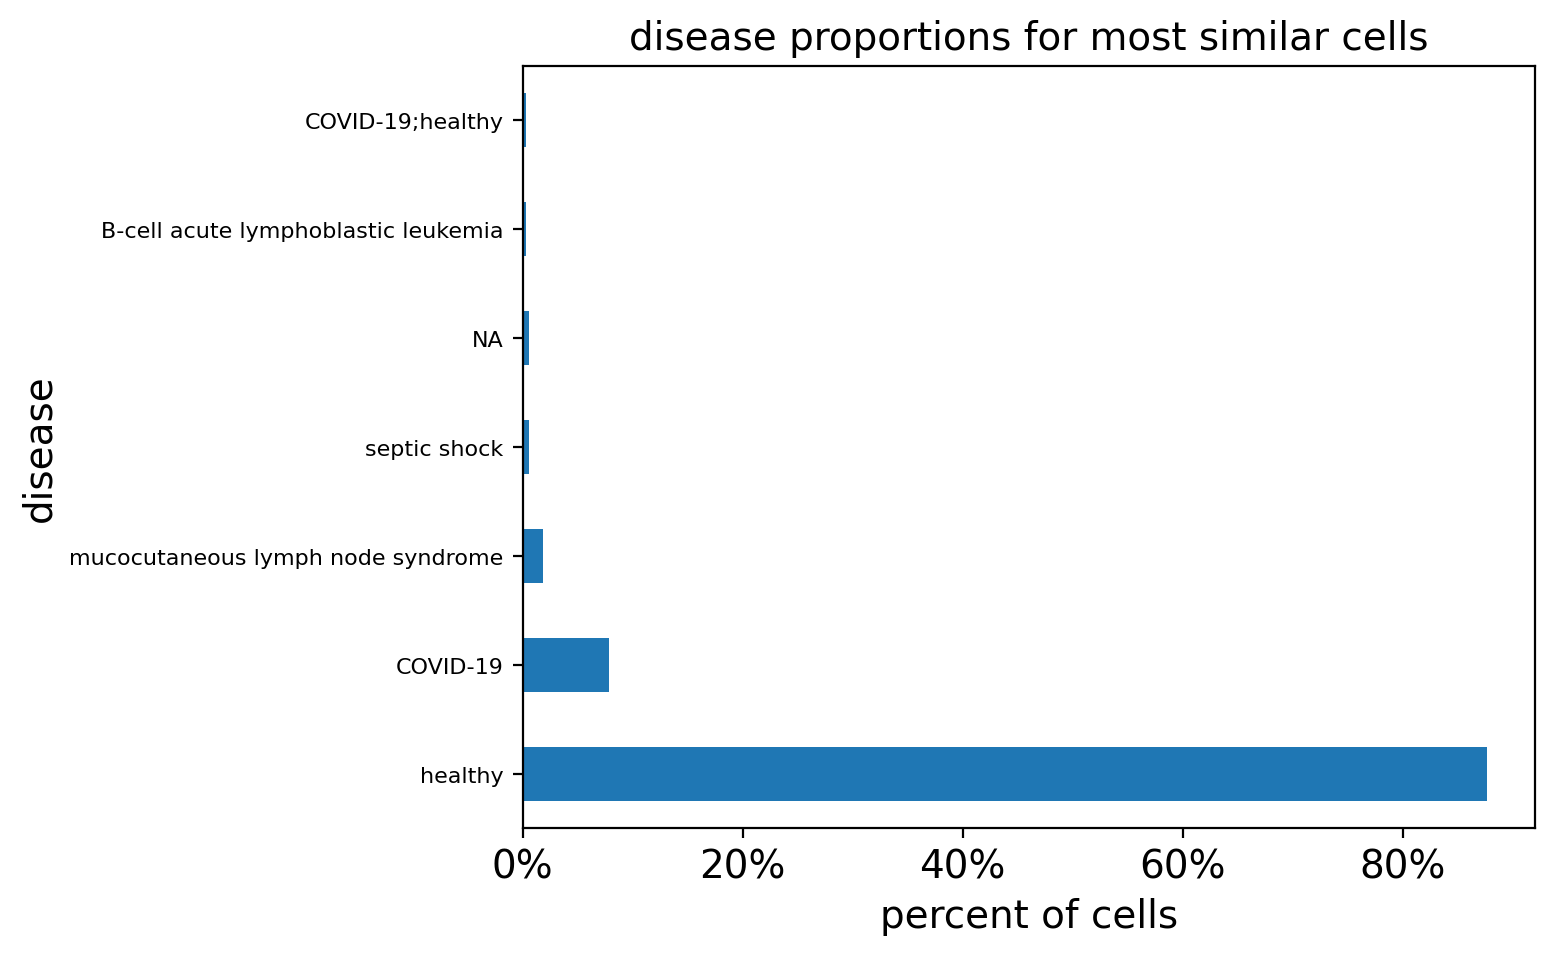

In [48]:
query_study = "DS000011735"
filtered_result_metadata = neutrophil_metadata[neutrophil_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

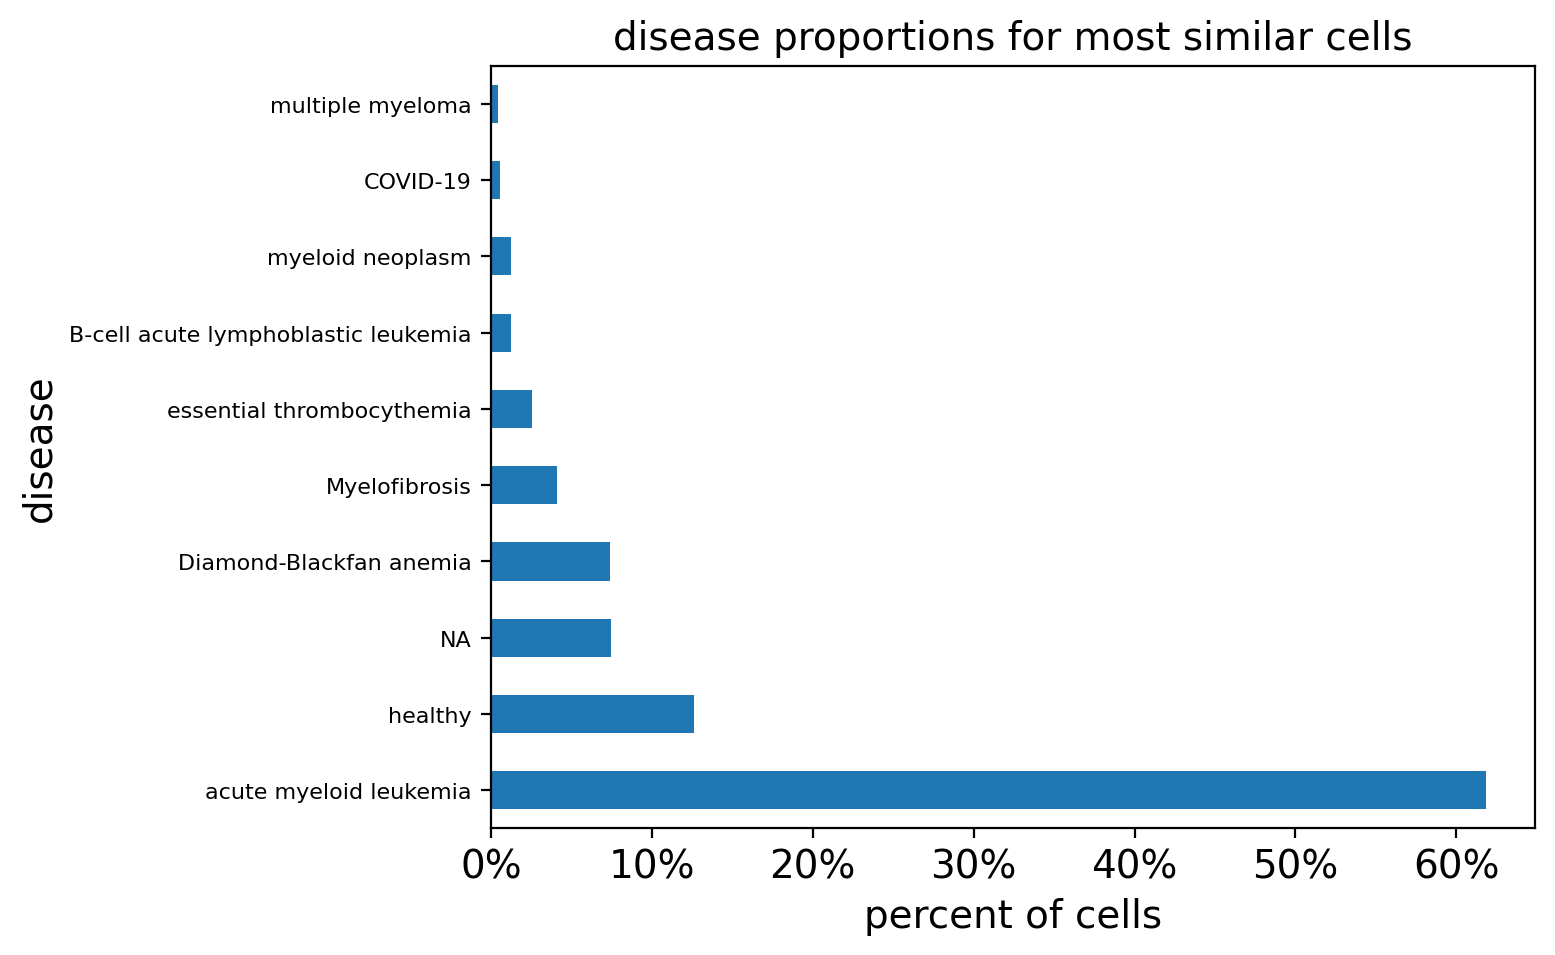

In [49]:
query_study = "DS000011735"
filtered_result_metadata = progenitor_metadata[progenitor_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)